In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import print_function
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import sys
import os
import glob

sys.path.insert(0, '../fcn8s')
from fcn8s import Inference

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans)

from MulticoreTSNE import MulticoreTSNE as MTSNE

# config = tf.ConfigProto( device_count = {'GPU': 0} )

colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
labels = ['G3', 'G4', 'G5', 'BN', 'ST']

In [3]:
# MODULE_URL = 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1'
MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/1'
# MODULE_URL = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/1'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

module = hub.Module(MODULE_URL)
height, width = hub.get_expected_image_size(module)
print(height, width)

image_in = tf.placeholder('float', [1, height, width, 3])
z_op = module(image_in)
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance

INFO:tensorflow:Initialize variable module/resnet_v2_50/block1/unit_2/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block1/unit_2/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_50/block1/unit_2/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block1/unit_2/bottleneck_v2/preact/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_50/block1/unit_2/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block1/unit_2/bottleneck_v2/preact/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_50/block1/unit_3/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables wit

INFO:tensorflow:Initialize variable module/resnet_v2_50/block2/unit_1/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block2/unit_1/bottleneck_v2/preact/beta
INFO:tensorflow:Initialize variable module/resnet_v2_50/block2/unit_1/bottleneck_v2/preact/gamma:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block2/unit_1/bottleneck_v2/preact/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_50/block2/unit_1/bottleneck_v2/preact/moving_mean:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block2/unit_1/bottleneck_v2/preact/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_50/block2/unit_1/bottleneck_v2/preact/moving_variance:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block

INFO:tensorflow:Initialize variable module/resnet_v2_50/block2/unit_3/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block2/unit_3/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_50/block2/unit_3/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block2/unit_3/bottleneck_v2/conv3/biases
INFO:tensorflow:Initialize variable module/resnet_v2_50/block2/unit_3/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block2/unit_3/bottleneck_v2/conv3/weights
INFO:tensorflow:Initialize variable module/resnet_v2_50/block2/unit_3/bottleneck_v2/preact/beta:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block2/unit_3/bottlene

INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_1/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_1/bottleneck_v2/conv2/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_1/bottleneck_v2/conv2/weights:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_1/bottleneck_v2/conv2/weights
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_1/bottleneck_v2/conv3/biases:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_1/bottleneck_v2/conv3/biases
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_1/bottleneck_v2/conv3/weights:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables wi

INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_3/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_3/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_3/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_3/bottleneck_v2/conv2/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_3/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_3/bottleneck_v2/conv2/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_3/bottleneck_v2/conv2/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e416

INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_5/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_5/bottleneck_v2/conv1/weights
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_5/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_5/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_5/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block3/unit_5/bottleneck_v2/conv2/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_50/block3/unit_5/bottleneck_v2/conv2/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/va

INFO:tensorflow:Initialize variable module/resnet_v2_50/block4/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block4/unit_1/bottleneck_v2/conv1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/resnet_v2_50/block4/unit_1/bottleneck_v2/conv1/weights:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block4/unit_1/bottleneck_v2/conv1/weights
INFO:tensorflow:Initialize variable module/resnet_v2_50/block4/unit_1/bottleneck_v2/conv2/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block4/unit_1/bottleneck_v2/conv2/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_50/block4/unit_1/bottleneck_v2/conv2/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38

INFO:tensorflow:Initialize variable module/resnet_v2_50/block4/unit_3/bottleneck_v2/conv1/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block4/unit_3/bottleneck_v2/conv1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/resnet_v2_50/block4/unit_3/bottleneck_v2/conv1/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block4/unit_3/bottleneck_v2/conv1/BatchNorm/gamma
INFO:tensorflow:Initialize variable module/resnet_v2_50/block4/unit_3/bottleneck_v2/conv1/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e4164630cc681b144e9c38d/variables/variables with resnet_v2_50/block4/unit_3/bottleneck_v2/conv1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/resnet_v2_50/block4/unit_3/bottleneck_v2/conv1/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/bf05a1aace97eed26e416

## Populate a matrix of feature vectors

In [28]:
jpg_list = sorted(glob.glob('../data/jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/mask/*.png'))

img_classes = []
orig_imgs = []

z_vectors = []
idx = 0

resize = 0.5
crop_size = int(height * (1/resize))

samples = 5
x0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
y0_vect = np.linspace(0, 1200-crop_size, samples, dtype=np.int)
coords = zip(x0_vect, y0_vect)

for img_idx, (jpg, mask) in enumerate(zip(jpg_list, mask_list)):
    y = cv2.imread(mask, -1)
    x = cv2.imread(jpg, -1)[:,:,::-1]
               
    for k in range(samples):
        x0 = np.random.randint(0, 1200-crop_size)
        y0 = np.random.randint(0, 1200-crop_size)
        
        ## Grab the majority label
        y_ = y[x0:x0+crop_size, y0:y0+crop_size]
        totals = np.zeros(5)
        for k in range(5):
            totals[k] = (y_==k).sum()

        # Check for majority
        maj = np.argmax(totals)   
        if totals[maj] > 0.5 * (crop_size**2):
            # check for stroma
#             if maj==4 and totals[maj] < 0.95 * (crop_size*2):
            if maj==4:
                continue
            else:
                img_classes.append(maj)
                orig_imgs.append(img_idx)
                idx += 1
                if idx % 250 == 0:
                    print(idx)
        
        else:
            continue

        x_ = x[x0:x0+crop_size, y0:y0+crop_size, :]
        x_ = cv2.resize(x_, dsize=(0,0), fx=resize, fy=resize)
        x_ = x_ * (1/255.)
        x_ = np.expand_dims(x_, 0)
        
        z = sess.run(z_op, feed_dict={image_in: x_})

        z_vectors.append(z)
    
    
z_vectors = np.concatenate(z_vectors, axis=0)

img_classes = np.asarray(img_classes)
orig_imgs = np.asarray(orig_imgs)
print('z vectors', z_vectors.shape)
print('img classes', img_classes.shape)
print('got classes:', np.unique(img_classes))

manifold = MTSNE(n_jobs=8, n_components=2, verbose=1)
z_manifold = manifold.fit_transform(z_vectors)
print('z manifold', z_manifold.shape)

250
500
750
1000
1250
z vectors (1331, 2048)
img classes (1331,)
got classes: [0 1 2 3]
z manifold (1331, 2)


## Cluter the z vectors

In [29]:
# clusterer = KMeans(n_clusters=5, n_jobs=4, verbose=0, n_init=25).fit(z_vectors)
clusterer = MiniBatchKMeans(n_clusters=4, verbose=0, n_init=100).fit(z_vectors)

Text(0.5,0.98,'ResNet-50 KMeans')

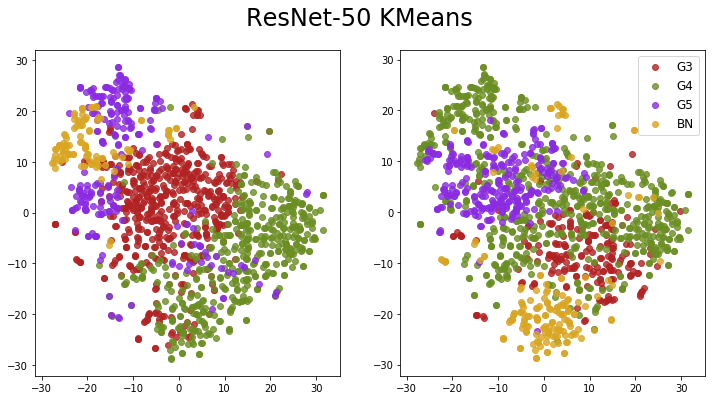

In [30]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

for k in range(4):
    idxs = np.where(clusterer.labels_==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], ax=axs[0])
    
    idxs = np.where(img_classes==k)
    sns.regplot(z_manifold[idxs,0], z_manifold[idxs,1], fit_reg=False, color=colors[k], label=labels[k], ax=axs[1])

plt.legend(fontsize=12)
plt.suptitle('ResNet-50 KMeans', fontsize=24)